## XII LEGISLATURA 

# Preprocessing

In [4]:
#import pymongo 
import pandas as pd
import logging
#import bson
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
import time
import pprint
import pickle
import random
import numpy as np
from sklearn.metrics import accuracy_score,precision_recall_curve, average_precision_score, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
import re
import json
import pandas
import operator
from functools import reduce
import editdistance
import copy
import regex
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from nltk.corpus import stopwords

In [2]:
pattern = '\w+|\$[\d\.]+|\S+'
tokenizer = RegexpTokenizer(pattern)

In [6]:
dataset_file = 'parliament/XII_legislature_italian_republic.json'

with open(dataset_file, 'r') as infile:
    dataset = json.load(infile)

In [7]:
len(dataset)

326

In [4]:
pprint(dataset[0]['link'])

'http://www.camera.it/_dati/leg12/lavori/stenografici/stenografico/32381.pdf'


## Controlli e test

In [15]:
#Verifico quanto spesso trovo l'intestazione della pagina e quale sia la sua lunghezza media

find = []
intro = ['Atti ', 'Alti ', 'A t t i ', 'Att i ', 'Alt i ', 'Allt ', 'At t i ', 'd t t i ']

for d in dataset:
    d['text'] = d['text'].replace('\n', '')
    year = d['date'].split('-')[0][1:4] #uso 948 perchè spesso c'è i948
    
    resulttot = []
    for i in intro:
        result = re.findall(i+'(.+?)'+year, d['text'])
        result = [i+elem+year for elem in result]
        
        resulttot.append(result)

    resulttot = reduce(operator.concat, resulttot)

    find.append(resulttot)

In [16]:
find = reduce(operator.concat, find)

In [27]:
cont = 0
lenght = []
for l in find:
    if len(l)>200:
        cont = cont+1
    if len(l)<4000:
        lenght.append(len(l))

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1cfd5190>,
 'caps': [<matplotlib.lines.Line2D at 0x105da3e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1cfd5090>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1cfb5f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1a6e9ad0>],
 'means': []}

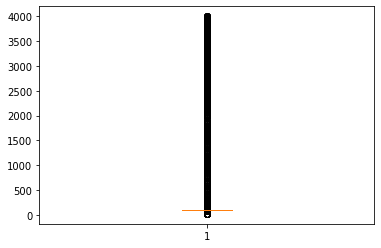

In [28]:
plt.boxplot(lenght)

In [30]:
np.median(lenght)

105.0

In [8]:
#voglio vedere quante volte riesco a trovare la dicitura che mi indica l'inizio della seduta

result = []  
for d in dataset:
        res = regex.search('(La){e<2}\s+(seduta){e<3}\s+(comincia){e<4}',d['text'])
        if res != None:
            result.append(res.group())

In [ ]:
pprint(len(result))
pprint((result))

In [14]:
#verifico quanto spesso trovo la fine della seduta e splitto in modo che isolo le cose che vengono dopo 

result = [] 
for d in dataset:
    if 'seduta' in d.keys():
        res = regex.search('(La){e<2}\s+(seduta){e<2}\s+(termina){e<3}',d['seduta'])
        if res != None:
            result.append(res.group())

In [ ]:
pprint(len(result))
pprint(result)

In [44]:
#cerco quante volte riesco a trovare l'inizio delle interrogazioni
#non vi sono interrogazioni

notresult = []
result = []
cont = 0

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(Si){e<2}\s+(dia){e<2}\s+(lettura){e<3}\s+(delle){e<2}\s+(interrogazioni){e<6}',d['seduta'])
        if res != None:
            result.append(res.group())
        else: notresult.append(cont)
    cont = cont + 1

In [9]:
#in fondo ho sempre le votazioni, splitto su di quelle che dopo di quelle non ho nulla di utile

notresult = []
result = []
cont = 0

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(VOTAZIONI){e<3}\s+(QUALIFICATE){e<3}\s+(EFFETTUATE){e<4}\s+(MEDIANTE){e<3}\s+(PROCEDIMENTO){e<4}\s+(ELETTRONICO){e<4}',d['seduta'])
        if res != None:
            result.append(res.group())
        else: notresult.append(cont)
    cont = cont + 1

In [10]:
#ne ho poche in quanto la maggior parte sono dopo la fine della seduta
pprint(len(result))

6


## Pulizia del testo

### Prima pulizia
Rimonzione \n e introduzione di ogni pagina

In [67]:
dataset_pulito = []
find = []
intro = ['Atti ', 'Alti ', 'A t t i ', 'Att i ', 'Alt i ', 'Allt ', 'At t i ', 'd t t i ']

for d in dataset:
    d['text'] = d['text'].replace('\n', ' ')
    year = d['date'].split('-')[0][1:4] #uso 996 perchè spesso c'è i996
    
    resulttot = []
    for i in intro:
        result = re.findall(i+'(.+?)'+year, d['text'])
        result = [i+elem+year for elem in result]
        result = [elem for elem in result if len(elem)< 160]
        
        resulttot.append(result)

    resulttot = reduce(operator.concat, resulttot)
    #pprint(resulttot)
    find.append(resulttot)
    
    for l in resulttot:
        d['text'] = d['text'].replace(l, '')
        
    dataset_pulito.append(d)

### Split inizio e fine seduta

In [68]:
#Splitto sull'inizio seduta

for d in dataset_pulito:
    res = regex.search('(La){e<2}\s+(seduta){e<3}\s+(comincia){e<4}',d['text'])
    if res !=None:
        split = d['text'].split(res.group())
        d.pop('text', None)
        d['index'],d['seduta'] = split[0], split[1]

In [69]:
#Lo trovo praticamente ovunque tranne in 3

cont = 0
for d in dataset_pulito:
    if 'index' not in d.keys():
        cont+=1
        
pprint(cont)

3


In [70]:
#Splitto la fine della seduts

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(La){e<2}\s+(seduta){e<2}\s+(termina){e<3}',d['seduta'])
        if res !=None:
            split = d['seduta'].split(res.group())
            d['seduta'],d['end'] = split[0], split[1]

### Split interrogazioni


In [71]:
#splitto sulle votazioni

for d in dataset_pulito:
    if 'seduta' in d.keys():
        res = regex.search('(VOTAZIONI){e<3}\s+(QUALIFICATE){e<3}\s+(EFFETTUATE){e<4}\s+(MEDIANTE){e<3}\s+(PROCEDIMENTO){e<4}\s+(ELETTRONICO){e<4}',d['seduta'])
        if res !=None:
            split = d['seduta'].split(res.group(),1)
            d['seduta'], d['votazioni'] = split[0], split[1]

### Presidenza

In [17]:
#voglio vedere quante volte riesco a trovare la dicitura che indica il presidente

notresult = []
result = []
cont = 0

for d in dataset_pulito:
    if 'index' in d.keys():
        res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<4}',d['index']) 
        
        if res != None:
            result.append(res.group())
        else:    
            res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['index']) 

            if res != None:
                result.append(res.group())
            else:
                notresult.append(cont)
    cont = cont +1

In [18]:
for i in notresult:
    d = dataset_pulito[i]
    
    if 'index' in d.keys():
        res = regex.search('(P R E S I D E N Z A D E L V I C E P R E S I D E N T E) {e<5}',d['index']) 
        if res != None:
                result.append(res.group())
        else:    
            res = regex.search('(P R E S I D E N Z A D E L P R E S I D E N T E) {e<5}',d['index']) 
            if res != None:
                result.append(res.group())

#trovo il presidente in tutti i casi tranne 3

In [11]:
pattern = '\w+|\$[\d\.]+|\S+'
tokenizer = RegexpTokenizer(pattern)

In [10]:
def find_presidente(data):
        pres = {}
        res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<4}',data) 
        
        if res != None:
            pres['presidente'] = data.split(res.group())[1]
            pres['presidente'] = tokenizer.tokenize(pres['presidente'])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]
            return pres
        
        elif regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',data) != None: 
            res = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',data)
            pres['presidente'] = data.split(res.group())[1]
            pres['presidente'] = tokenizer.tokenize(pres['presidente'])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]
            return pres
        
        elif regex.search('(P R E S I D E N Z A D E L V I C E P R E S I D E N T E) {e<5}',data) != None:
            res = regex.search('(P R E S I D E N Z A D E L V I C E P R E S I D E N T E) {e<5}',data)
            pres['presidente'] = data.split(res.group())[1]
            pres['presidente'] = tokenizer.tokenize(pres['presidente'])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]
            return pres
        
        elif regex.search('(P R E S I D E N Z A D E L P R E S I D E N T E) {e<5}',data) != None:
            res = regex.search('(P R E S I D E N Z A D E L P R E S I D E N T E) {e<5}',data)
            pres['presidente'] = data.split(res.group())[1]
            pres['presidente'] = tokenizer.tokenize(pres['presidente'])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]
            return pres
        
        else: return False
        
        #quando ho indi vuol dire che ho doppio presidente

In [72]:
#Vado a salvare il campo presidente

presidenza = []
result = []
cont = 0

for d in dataset_pulito:
    if 'index' in d.keys():
        check = False
        pres = find_presidente(d['index'])
        
        if regex.search('(PROVVISORIO){e<4}',pres['presidente'][0]) != None :
                check = True
                
        if check == True:
            if pres['presidente'][3].isupper() and len(pres['presidente'][3])>1 and pres['presidente'][3][0:4]!= 'INDI':
               pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]+" "+pres['presidente'][3]
               
            else:  
                pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]
               
        else:
            if pres['presidente'][2].isupper() and len(pres['presidente'][2])>1 and pres['presidente'][2][0:4]!= 'INDI':
                pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]+" "+pres['presidente'][2]
            else:   pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]
        

        d['presidente'] = [pres['presidente']]  #salvo tutto come presidente, non tengo la distinzione
        
    else:
        pres = {}
        pres['presidente'] = []
   
    pres['doc'] = cont

    presidenza.append(pres)
    cont = cont+1


In [ ]:
pprint(presidenza) #violante, la russa, dotti, acquarone, della valle, irene P

In [74]:
pickle.dump( dataset_pulito, open("Dataset_pulito.nosync/dataset_pulito_XII_prima.p", "wb" ) )

In [75]:
dataset_pulito = pickle.load( open("Dataset_pulito.nosync/dataset_pulito_XII_prima.p", "rb" ))

In [ ]:
cont = 0
pres = {}

for d in dataset_pulito: 
    if 'seduta' in d.keys() and 'presidente' in d.keys():
        d['seduta'] = [d['seduta']]
        i = 0
        res = None
        
        r = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<6}',d['seduta'][0])
        if r!= None:
            res = r

        r = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['seduta'][0])
        if r != None and res!= None and r.span()[0]<res.span()[0]:
            res = r

        r = regex.search('(P R E S I D E N Z A D E L V I C E P R E S I D E N T E) {e<5}',d['seduta'][0])
        if r != None and res!= None and r.span()[0]<res.span()[0]:
            res = r    
            
        r = regex.search('(P R E S I D E N Z A D E L P R E S I D E N T E) {e<5}',d['seduta'][0])
        if r != None and res!= None and r.span()[0]<res.span()[0]:
            res = r 

        while res != None: #continuo a splittare finchè trovo che c'è un nuovo presidente
            check = False
            split = d['seduta'][i].split(res.group(),1)
            d['seduta'].pop(i)
            d['seduta'].append(split[0])
            d['seduta'].append(split[1])

            pres['presidente'] = tokenizer.tokenize(split[1])
            pres['presidente'] = [x for x in pres['presidente'] if x not in punctuation]

            if regex.search('(PROVVISORIO){e<4}',pres['presidente'][0]) != None :
                check = True
                
            if check == True:
                if pres['presidente'][3].isupper() and len(pres['presidente'][3])>1 and pres['presidente'][3] != 'PRESIDENTE' and pres['presidente'][3][0]!='(':
                    pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]+" "+pres['presidente'][3]
                else:   pres['presidente'] = pres['presidente'][1]+" "+pres['presidente'][2]

            else:
                 if pres['presidente'][2].isupper() and len(pres['presidente'][2])>1 and pres['presidente'][2] != 'PRESIDENTE'and pres['presidente'][2][0]!='(':
                    pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]+" "+pres['presidente'][2]
                 else:   pres['presidente'] = pres['presidente'][0]+" "+pres['presidente'][1]

            d['presidente'].append(pres['presidente'])
            
            i = i +1
            
            res = None

            r = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(PRESIDENTE){e<6}',d['seduta'][i])
            if r!= None:
                res = r

            r = regex.search('(PRESIDENZA){e<4}\s+(DEL){e<3}\s+(VICEPRESIDENTE){e<6}',d['seduta'][i])
            if r != None and res!= None and r.span()[0]<res.span()[0]:
                res = r

            r = regex.search('(P R E S I D E N Z A D E L V I C E P R E S I D E N T E) {e<5}',d['seduta'][i])
            if r != None and res!= None and r.span()[0]<res.span()[0]:
                res = r    
            
            r = regex.search('(P R E S I D E N Z A D E L P R E S I D E N T E) {e<5}',d['seduta'][i])
            if r != None and res!= None and r.span()[0]<res.span()[0]:
                res = r 
            
    pprint(cont)       
    cont = cont+1

In [ ]:
cont = 0
res = []
for d in dataset_pulito:
    if 'presidente' in d.keys() and len(d['presidente'])>1:
        print(d['presidente'])
        res.append(cont)
    cont = cont+1

In [94]:
pickle.dump( dataset_pulito, open("Dataset_pulito.nosync/dataset_pulito_XII.p", "wb" ) )

## Divisione dei discorsi

In [35]:
dataset_pulito = pickle.load( open( "Dataset_pulito.nosync/dataset_pulito_XII.p", "rb" ) )

### Estrazione nomi dei politici

In [6]:
#non i nomi dei leader, li devo estrarre, ho sempre nome e cognome, a parte per il presidente

In [ ]:
#inserisco tutti i presidenti che ho trovato
politici = {}

for d in dataset_pulito:
    if 'presidente' in d.keys():
        cont = 0
        for p in d['presidente']:
            pres = p.split(' ')
            pres1 = pres[0]+" "+pres[1]
            if pres1 != 'IGNAZIO LA' and pres1 != 'RAFFAELE DELLA' and len(pres)>2:
                pprint(d['presidente'][cont])
                d['presidente'][cont] = pres1
                pprint(d['presidente'][cont])
            cont = cont +1

In [37]:
len_p = []
for d in dataset_pulito:
    if 'presidente' in d.keys():
        for p in d['presidente']:
             len_p.append(len(d['presidente']))

In [38]:
pprint(np.max(len_p))
pprint(np.mean(len_p))
pprint(np.median(len_p))

7
2.24031007751938
2.0


In [39]:
politici = {}

for d in dataset_pulito:
    if 'presidente' in d.keys():
        for p in d['presidente']:
            if p not in politici.keys():
                politici[p] = 1

In [40]:
pprint(politici)

{'I G': 1,
 'I R': 1,
 'IGNAZIO L': 1,
 'IGNAZIO LA': 1,
 'IGNAZIO LA RUSSA': 1,
 'IREN E': 1,
 'IRENE P': 1,
 'IRENE PIVEITI': 1,
 'IRENE PIVETIT': 1,
 'IRENE PIVETTI': 1,
 'IRENE PIVETTT': 1,
 'IRENE PIVETTl': 1,
 'IRENE R': 1,
 'IRENE RIVETTI': 1,
 'L O': 1,
 'L U': 1,
 'LORENZO A': 1,
 'LORENZO ACOUARONE': 1,
 'LORENZO ACQUARONE': 1,
 'LUCIANO V': 1,
 'LUCIANO VIOLANTE': 1,
 'P R': 1,
 'R A': 1,
 'RAFFAELE D': 1,
 'RAFFAELE DELLA VALLE': 1,
 'RAFFAELE DELLA \\ALLE': 1,
 'VITTORIO D': 1,
 'VITTORIO DOTTI': 1}


In [41]:

cont = 0
flag = 0

for data in dataset_pulito:
    if 'seduta' in data.keys():
        for k in range(0,len(data['seduta'])):
            presidente = data['presidente'][k]
            
            text = data['seduta'][k]
            text_token = tokenizer.tokenize(text)
            text_token = [x for x in text_token if x not in punctuation]

            for i in range(0,len(text_token)):

                    word = text_token[i]
                    politico = re.search(r"[A-Z]{4,}", word)

                    if politico != None and i+2<len(text_token):
                        if editdistance.eval(politico.group(), 'PRESIDENTE')<4:
                            pol = presidente
                            politici[pol] = politici[pol]+1
                        
                        else:
                            if flag == 0: 
                                flag = 0
                                if text_token[i+1].isupper() and len(text_token[i+1])>1 and text_token[i+1][0]!='(' : #ignoro cose tipo XIII legisl

                                    if text_token[i+2].isupper() and len(text_token[i+2])>2 and text_token[i+2][0]!='(':
                                        pol = word+" "+text_token[i+1]+" "+text_token[i+2]

                                        if pol not in politici.keys():
                                            politici[pol] = 1
                                        else: politici[pol] = politici[pol]+1
                                        flag = 2


                                    else:
                                        pol = word+" "+text_token[i+1]
                                        if pol not in politici.keys():
                                            politici[pol] = 1
                                        else: politici[pol] = politici[pol]+1
                                        flag = 1

                            else: flag = flag -1

            cont = cont +1

In [ ]:
pprint((sorted(politici)))

In [ ]:
pprint((sorted(politici)))

In [43]:
pprint(len(politici))

1420


In [44]:
politici_max = [] #tengo solamente quelli con almeno 3 occorrenze

for k in politici.keys():
    if politici[k] > 2:
        politici_max.append([k, politici[k]])

In [45]:
pprint(len(politici_max))
#li considero come tutti i politici
#lo uso per scartare quelli che non dovrebbero essere politici

760


In [46]:
politici_max_name = [elem[0] for elem in politici_max]

In [ ]:
pprint(sorted(politici_max))

In [48]:
#li aggrego in base alle somiglianze nel nome

politici_definitivi = []
cont = 1

for p in politici_max:
    for i in range(cont, len(politici_max)):
        if len(p[0]) <=  10 and editdistance.eval(p[0],politici_max[i][0])<3:
            p[1] = p[1] + politici_max[i][1]
            politici_max[i][1] = 0
        
        if len(p[0]) > 10 and editdistance.eval(p[0],politici_max[i][0])<4:
            p[1] = p[1] + politici_max[i][1]
            politici_max[i][1] = 0
            
    cont = cont +1
    

In [49]:
#elimino quelli che sono stati aggregati
politici_max_agg = [elem for elem in politici_max if elem[1]>0]


In [50]:
pprint(len(politici_max_agg))

641


In [ ]:
pprint(sorted(politici_max_agg))

In [52]:
politici_max_def = [elem for elem in politici_max if elem[1]>70]

In [53]:
pprint(len(politici_max_def))

#90 politici hanno almeno 70 discorso, vanno cmq ripuliti

91


In [ ]:
pprint(politici_max_def)

In [ ]:
pprint(politici_max_def)

In [55]:
politici_max_def.remove(['LEGISLATURA DISCUSSIONI SEDUTA', 2456])
politici_max_def.remove(['P R', 565])

In [56]:
politici_max_def_name = [elem[0] for elem in politici_max_def]

In [57]:
len(politici_max_name)

760

In [58]:
politici_max_name.remove('LEGISLATURA DISCUSSIONI SEDUTA')

In [59]:
politici_max_name.remove('P R')

### Estrazione e salvataggio dei discorsi

Nei politici rilevanti lascio comunque i nomi scritti male tipo IRENE P in quanto altrimenti perderei tanti discorsi, poi alla fine aggregherò tutto.
Quando vado a cercare i nomi nel documento devo tenere conto della edit distance con cui ho aggregato la lista di nomi e farla uguale.
Nel testo ho sempre nome e congnome quindi devo sempre tenere conto del token e del token successivo, a parte nel caso del presidente

In [156]:
def check_politico(pol):
        
    for cog in politici_max_def_name:
            res = editdistance.eval(cog,pol)
            
            if len(pol)  <= 10 and res<3:
                return True, cog
                
            if len(pol) > 10 and res<4:
                return True, cog
    
    return False, None

In [ ]:
pprint(sorted(politici_max_def_name))

In [60]:
politici_max_def_name.remove('PARERE CONTRARIO')
politici_max_def_name.remove('PARERE FAVOREVOLE')
politici_max_def_name.remove('NULLA OSTA')
politici_max_def_name.remove('DISCUSSIONI SEDUTA DEL')

In [61]:
politici_max_name.remove('PARERE CONTRARIO')
politici_max_name.remove('PARERE FAVOREVOLE')
politici_max_name.remove('NULLA OSTA')
politici_max_name.remove('DISCUSSIONI SEDUTA DEL')

In [62]:
discorsi = {}

for cog in politici_max_def_name:
    discorsi[cog] = []

In [ ]:
pprint(discorsi)

In [ ]:
#Salvo i discorsi

cont = 0
flag = 0
d = {}


for data in dataset_pulito:
    if 'seduta' in data.keys():
         for k in range(0,len(data['seduta'])):
            presidente = data['presidente'][k]
            
            text = data['seduta'][k]
            text_token = tokenizer.tokenize(text)
            text_token = [x for x in text_token if x not in punctuation]
            i = 0
            flag = 0
            d = {}

            for word in text_token:

                    politico = re.search(r"[A-Z]{4,}", word)

                    if politico != None and i+2<len(text_token):
                        
                        if editdistance.eval(politico.group(), 'PRESIDENTE')<4:
                            pprint(politico.group())
                            
                            if d!={} and len(d['discorso'])>2:
                                discorsi[d['politico']].append(d['discorso'])
                                pprint(str(cont)+' '+d['politico'])
                            
                                
                            flag = 0
                            d = {}
                            
                            pres, cog_pres = check_politico(presidente) #controllo se il presidente mi interessa
                            
                            if pres == True:
                                d['politico'] = cog_pres
                                d['discorso'] = []
                                flag = 1
                        
                        else:
                            pol = politico.group()+" "+text_token[i+1]
      
                            pol2 =  politico.group()+" "+text_token[i+1]+" "+text_token[i+2]
             
                            
                            if (pol in politici_max_name) or (pol2 in politici_max_name): #se non è in questa lista non lo considero un politico 
                                    if d!={} and len(d['discorso'])>2: #salvo perchè significa che inizia un altro discorso
                                        discorsi[d['politico']].append(d['discorso'])
                                        pprint(str(cont)+' '+d['politico'])
                                        
                                    
                                    flag = 0
                                    d = {}

                                    if text_token[i+2].isupper() and len(text_token[i+2])>2 and text_token[i+2][0]!='(': 
                                        check, cog = check_politico(pol2)
                                        if check == True:
                                            d['politico'] = cog
                                            d['discorso'] = []
                                            text_token.pop(i+1)
                                            text_token.pop(i+1)
                                            flag = 1

                                    else:
                                        check, cog = check_politico(pol)
                                        if check == True:
                                            flag = 1
                                            d['politico'] = cog
                                            d['discorso'] = []
                                            text_token.pop(i+1)

                            elif flag == 1: #vuol dire che è una parola in maiuscolo ma non è un politico
                                d['discorso'].append(word)
                         
                    elif flag ==1:
                        d['discorso'].append(word)
                    i = i +1
                    
            if d != {} and len(d['discorso'])>2: 
                discorsi[d['politico']].append(d['discorso'])
                pprint(str(cont)+' '+d['politico'])
               
    cont = cont +1

In [ ]:
#Devo aggregare i politici per nome, va fatto a mano in quanto alcuni non si riesce a metterli insieme automatic.

for k in sorted(discorsi.keys()):
    print(k+" "+str(len(discorsi[k])))

In [64]:
for d in discorsi['IGNAZIO L']:
    discorsi['IGNAZIO LA RUSSA'].append(d)

In [65]:
discorsi.pop('IGNAZIO L')

[]

In [66]:
for d in discorsi['IRENE P']:
    discorsi['IRENE PIVETTI'].append(d)

discorsi.pop('IRENE P')

[]

In [67]:
for d in discorsi['LORENZO A']:
    discorsi['LORENZO ACQUARONE'].append(d)

discorsi.pop('LORENZO A')

[]

In [68]:
for d in discorsi['LUCIANO V']:
    discorsi['LUCIANO VIOLANTE'].append(d)

discorsi.pop('LUCIANO V')

[]

In [69]:
for d in discorsi['RAFFAELE D']:
    discorsi['RAFFAELE DELLA \ALLE'].append(d)

discorsi.pop('RAFFAELE D')

[]

In [184]:
leng = []
for k in discorsi.keys():
    leng.append(len(discorsi[k]))

In [187]:
pprint(np.mean(leng))

352.175


In [179]:
#Salvo un file per ciascun politico con i suoi discorso

for cog in discorsi.keys():
    pickle.dump( discorsi[cog], open( 'Discorsi-XII-legis/'+cog+".p", "wb" ) )
    

In [71]:
pickle.dump( list(discorsi.keys()), open( 'Discorsi-XII-legis/cognomi_discorsi.p', "wb" ) ) #da risalvare

### punto della situazione

#### Cose fatte:
1. Ripulito il testo dall'intestazione
2. Splittatto in index, seduta, seduta_2, votazioni e fine seduta (end)
3. Trovato il presidente e splittato la seduta tutte le volte
4. Isolato una lista dei politici più presenti (con almeno 70 discorsi)
5. Estratto i discorsi mettendo la soglia ad almeno 70 e salvati in file pickle, uno per ogni politico
                                               
80 politici di interesse - 352 discorsi in media con mediana 109 - con soglia a 70


